In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [57]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

R   = 25*1e6
Cm  = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs  = self_capacitance_sphere(3.9, 10)

## DC Input - Voltage Distribution - Closed Circuit

In [58]:
# folder  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 50000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv")['Current'].values for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

### Steady State

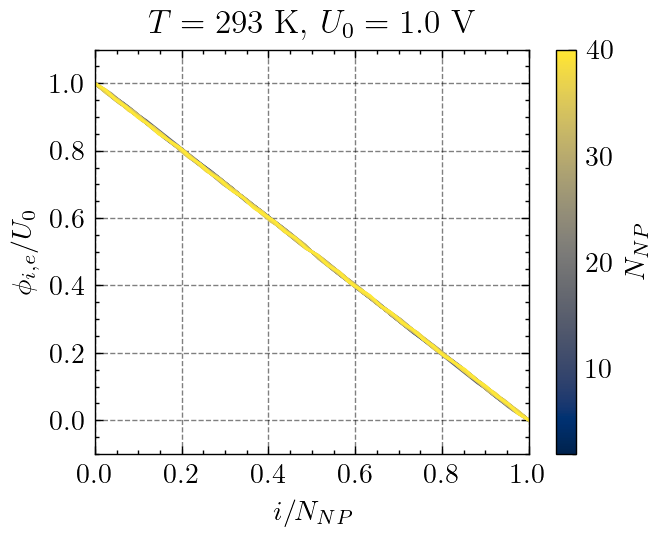

In [59]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    p   = np.append(p, 0.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_potential.svg", transparent=True)

- Potential decays linearly from $U_0$ to $0$ V, which confirms the **Ohmic response** of the string $$\phi_i = U_0 (1 - \frac{i}{N_{NP}})$$
- Equal potential difference $\Delta \phi = \frac{U_0}{N_{NP}}$ imply uniform **voltage drops** across each junction

### Characteristic Time Scale

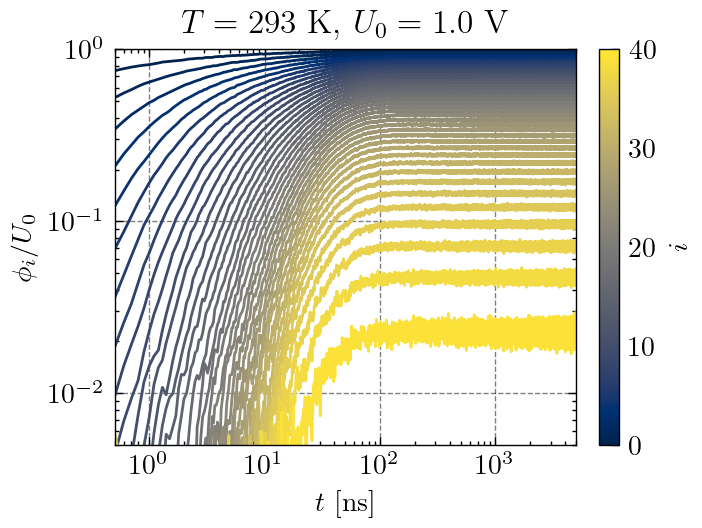

In [68]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
norm    = Normalize(vmin=0, vmax=Np)

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0.5,5000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

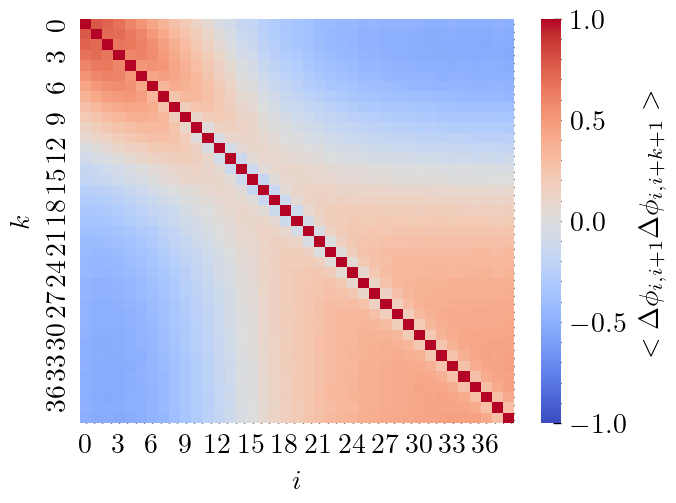

In [8]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Strong short range correlations: Diffusive charge spreading
- Long range anti-correlations: Charges at distant NPs adjust to maintain linear potential gradient globally

In [119]:
def characteristic_time(t_vals, pot_df, Np, steady_start=45000, consecutive_points=1, p_th=0.632):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0, t0):
        t_shift = np.clip(t - t0, 0, None)
        return a0*(1 - np.exp(-t_shift / tau))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, _    = curve_fit(saturation_cuve, x, y, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        tau.append(p[0])
        params.append(p)

    return tau, params

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0):

    def stretched_saturation_curve(t, tau, a0, t0, beta):
        t_shift = np.clip(t - t0, 0, None)
        return a0*(1 - np.exp(-(t_shift/tau)**beta))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, _    = curve_fit(stretched_saturation_curve, x, y, p0=p0[i,:], bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))
        tau_val = gamma(1/p[3])*p[0]/p[3]
        tau.append(tau_val)
        params.append(p)
        # print(p)

    return tau, params

In [122]:
tau_dict    = {}
tau_s_dict  = {}

for Np in N_vals:

    # Single exponential
    taus, params    = characteristic_time_saturation(t_vals, pot, Np)
    # taus            = characteristic_time(t_vals, pot, Np)
    tau_dict[Np]    = taus

    # Stretched exponential
    # p0_vals                             = np.hstack((np.array(params),np.ones(shape=(Np,1))))
    # taus_stretched, params_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)
    # tau_s_dict[Np]                      = taus_stretched

taus_max    = [np.max(tau_dict[Np]) for Np in N_vals]
# taus_s_max  = [np.max(tau_s_dict[Np]) for Np in N_vals]

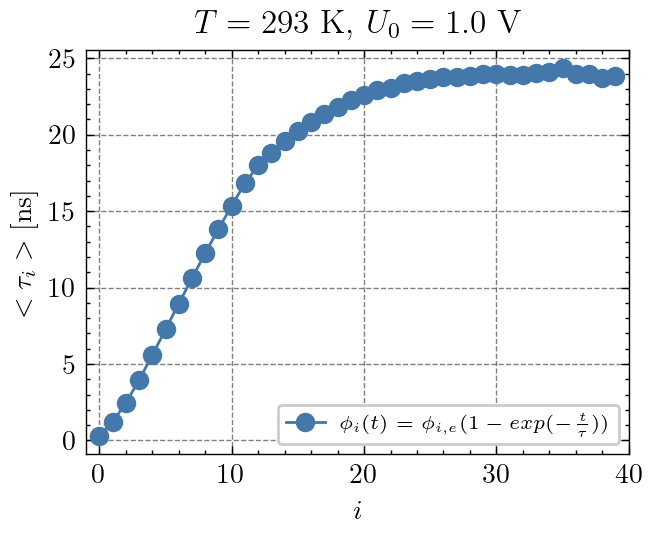

In [123]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, tau_dict[Np], '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(xp, tau_s_dict[Np], '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,60)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_scales.svg", transparent=True)

In [124]:
def tau_analytic(N, R, Cs, Cm):
    """
    Slowest RC time of an N-site 1-D nanoparticle chain.

    Parameters
    ----------
    N   : int      # number of nanoparticles in the string
    R   : float    # junction resistance  (Ω)
    Cs  : float    # self-capacitance     (F)
    Cm  : float    # mutual capacitance   (F)
    """
    base = R * Cs * (N + 1)**2 / (np.pi**2)                 #  leading term
    corr = 1 + (Cm / Cs) * (np.pi**2) / (2 * (N + 1)**2)    #  first-order edge / mutual correction
    return base * corr

def tau_numeric(N, R, Cs, Cm, eps_rel=1e-6):
    """
    Slowest RC time of an N-site chain.
    End nodes are *included* but the spurious λ≈0 mode is discarded.
    """
    # --- build C ---
    C = np.zeros((N, N))
    for i in range(N):
        C[i, i] = Cs + (2*Cm if 0 < i < N-1 else Cm)
        if i > 0:
            C[i, i-1] = C[i-1, i] = -Cm

    # --- build G ---
    G = np.zeros((N, N))
    for i in range(N):
        if i > 0:
            G[i, i-1] = -1 / R
        if i < N-1:
            G[i, i+1] = -1 / R
        G[i, i] = -G[i].sum()

    # eigen-values of C⁻¹G
    lam = np.real(np.linalg.eigvals(np.linalg.solve(C, G)))
    lam_max = lam.max()
    lam_pos = lam[lam > lam_max * eps_rel]      # keep only “real” modes
    return 1 / lam_pos.min()

taus_ana    = tau_analytic(np.array(N_vals), R, Cs, Cm)*1e9
taus_num    = np.array([tau_numeric(N, R, Cs, Cm)*1e9 for N in N_vals])
taus_ana

array([ 0.12694014,  0.30283371,  0.56667407,  0.91846122,  1.35819516,
        1.88587588,  2.5015034 ,  3.20507769,  3.99659878,  4.87606666,
        5.84348132,  6.89884277,  8.042151  ,  9.27340603, 10.59260784,
       11.99975644, 13.49485182, 15.07789399, 16.74888295, 18.5078187 ])

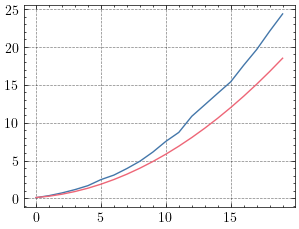

In [125]:
plt.plot(taus_max)
plt.plot(taus_ana)

Text(0.5, 1.0, '$T = 293$ K, $U_0 = 1.0$ V')

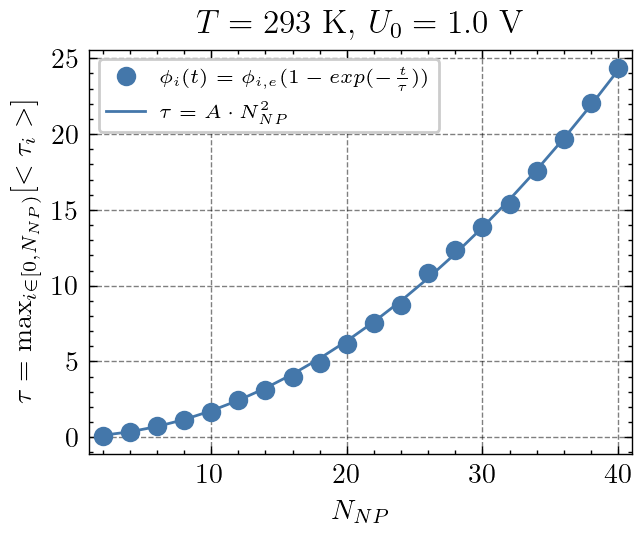

In [126]:
def quad_func(x, a):
    return a*(x+1)**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, taus_max)
pp  = ax.plot(N_vals, taus_max, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ps,_    = curve_fit(quad_func, N_vals, taus_s_max)
# pp      = ax.plot(N_vals, taus_s_max, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *ps), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")
# ax.plot(N_vals, tau_i, color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
# ax.set_ylim(0,30)
ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

# fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

$$\tau_{\text{slow}}=\frac{R_\text{eff}\,C_{\Sigma}}{\pi^{2}}\,(N+1)^{2}, \qquad R_\text{eff}= \begin{cases} R_{\text{t}}, & \text{(RC regime)} \\[4pt] R_{\text{SE}}(T,V), & \text{(SE regime)} \end{cases}$$

**Why $N^{2}$?** A 1-D RC ladder is formally a diffusion line; the longest spatial wavelength that fits in length $Na$ has $k_{\min}\!=\!\pi/(N+1)a$, so the relaxation time goes like $1/k_{\min}^{2}$.
| quantity | symbol | value you gave | comment |
|----------|--------|---------------|---------|
| total node capacitance | $C_\Sigma$ | $C_0+2C\approx 3\;\mathrm{aF}$ | identical sites |
| charging energy | $E_C=e^{2}/2C_\Sigma\approx 27\;\mathrm{meV}$ | matches aF scale |
|thermal energy | $k_B T$ | 25 meV @ 293 K ⟂ 0.43 meV @ 5 K | CB off vs on |
| bias in your runs | $V_\text{in}$ | 0.10 V (293 K) ⟂ 0.02 V (5 K) | above vs **below** CB threshold $E_C/e≈0.027\;\text{V}$ |

**293 K, 0.10 V** $k_BT\sim E_C$ *and* $eV\gg E_C$ → Coulomb blockade negligible. Use $R_\text{eff}=R_t$.
For $R_t=100\;\text{M}\Omega,\;C_\Sigma=3\;\text{aF},\;N=20$: $\tau_{\text{slow}}\approx$ **13 ns** (numbers in python check). * **5 K, 0.02 V** $k_BT\ll E_C$ and bias is **below threshold** → sequential tunnelling is Arrhenius-suppressed:
$$R_{\text{SE}}\approx R_t\,\exp\!\Bigl[\frac{E_C}{k_BT}\Bigr]\; \bigl(\tfrac{E_C}{e|V|}-1\bigr)^{-1}\;{\Rightarrow}\; R_{\text{SE}}\;\text{in the}\;\mathrm{G}\Omega\text{–}\mathrm{T}\Omega\;\text{range}$$

- $N^2$ dependence as we have **diffusive-limited relaxation** (governed by $R$ and $C$)
- We get about the same prefactor as theory suggests. Deviations due to finite-$N$
- We have a ***hierarchical timescale*** of eigenmodes, i.e. first NPs relax faster and last NP are driven by slowest mode

## DC Input - Voltage Distribution - Open Circuit

In [32]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 50000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

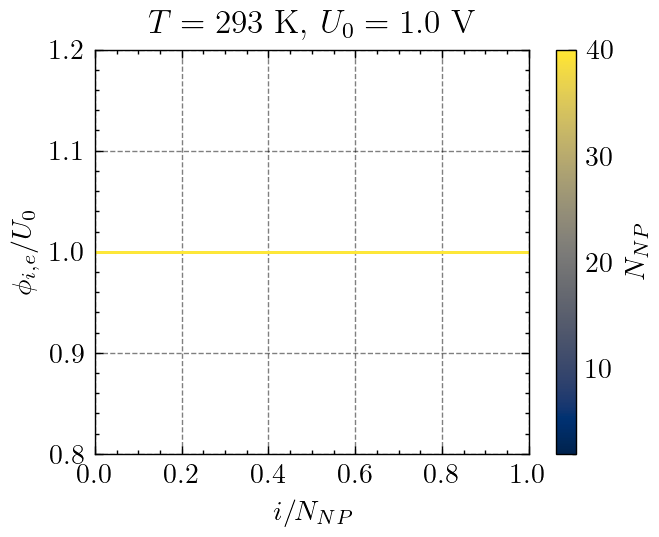

In [38]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential.svg", transparent=True)

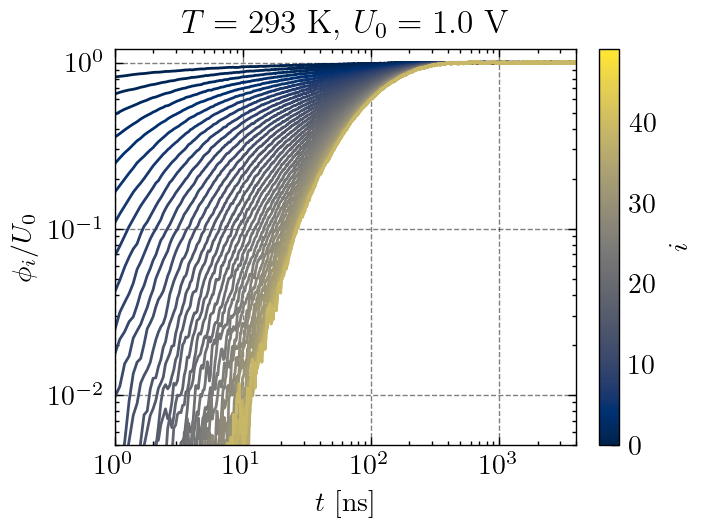

In [39]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)
Np      = 40

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_series.svg", transparent=True)

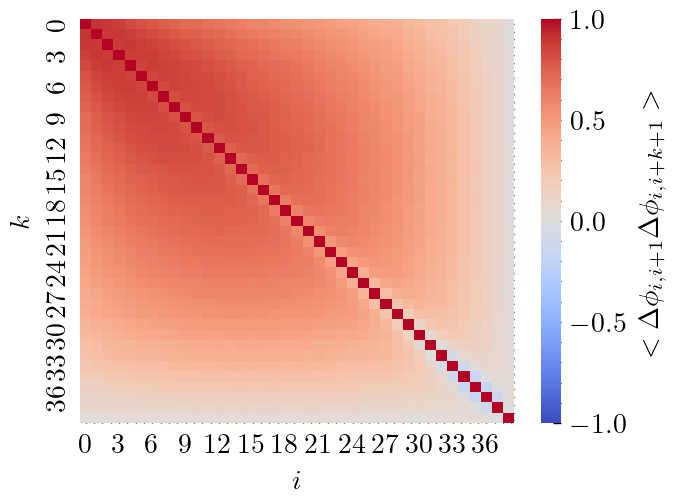

In [40]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_diff_corr.svg", transparent=True)

- Without a ground path, charges accumulate until the **entire string floats** at $U_0$ --> $\phi_i \approx U_0 \forall i$

In [41]:
tau_dict    = {}
tau_s_dict  = {}

for Np in N_vals:

    # Single exponential
    taus, params    = characteristic_time_saturation(t_vals, pot, Np)
    tau_dict[Np]    = taus

    # Stretched exponential
    p0_vals                             = np.hstack((np.array(params),np.ones(shape=(Np,1))))
    taus_stretched, params_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)
    tau_s_dict[Np]                      = taus_stretched

taus_max    = [np.max(tau_dict[Np]) for Np in N_vals]
taus_s_max  = [np.max(tau_s_dict[Np]) for Np in N_vals]

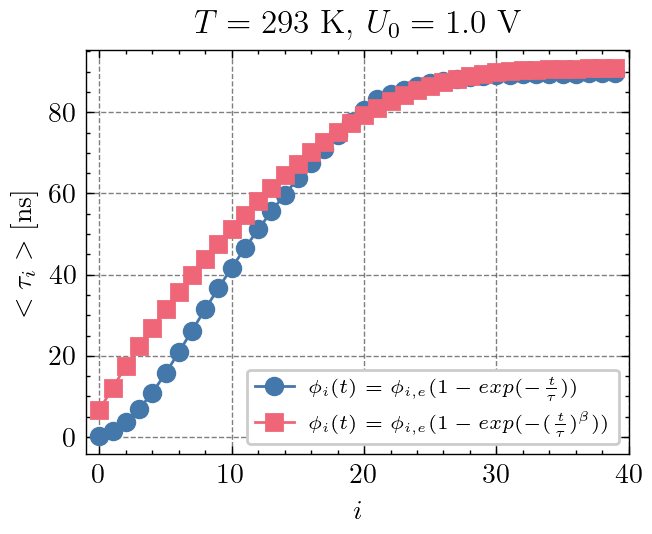

In [44]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,60)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_scales.svg", transparent=True)

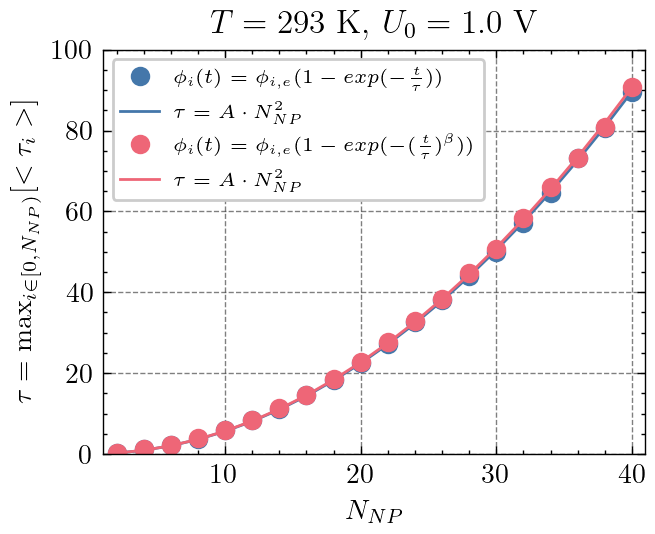

In [54]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, taus_max)
pp  = ax.plot(N_vals, taus_max, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, taus_s_max)
pp  = ax.plot(N_vals, taus_s_max, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,100)
ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_time_scales_vs_N.svg", transparent=True)